# Text-Classification

## Import Libraries

In [100]:
import tensorflow as tf
import numpy as np
import string
import re
from keras.layers import TextVectorization
from keras.layers import Input, Embedding, Dropout, Dense
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras import Model
import matplotlib.pyplot as plt

## Load Data

### Download Data

In [2]:
## IMDB sentiment classification dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 80.2M    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 80.2M    0 81920    0     0  40544      0  0:34:34  0:00:02  0:34:32 40574
  0 80.2M    0  368k    0     0   121k      0  0:11:14  0:00:03  0:11:11  121k
  1 80.2M    1 1456k    0     0   358k      0  0:03:48  0:00:04  0:03:44  358k
  6 80.2M    6 5536k    0     0  1090k      0  0:01:15  0:00:05  0:01:10 1090k
 17 80.2M   17 14.2M    0     0  2394k      0  0:00:34  0:00:06  0:00:28 2876k
 32 80.2M   32 25.7M    0     0  3771k      0  0:00:21  0:00:06  0:00:15 5289k
 47 80.2M   47 37.7M    0     0  4814k      0  0:00:17  0:00:08  0:00:09 7648k
 64 80.2M   64 51.4M    0     0  5770k      0  0:00:14  0:00:09  0:00:05  9.8M
 76 80.2M   76 61.7M    0     0  6329k      0  0:00

### Data Split

In [79]:
batch_size = 64
validation_split = 0.2

## train data
raw_train_ds = tf.keras.utils.text_dataset_from_directory(r"aclImdb\train", 
                                                          batch_size = batch_size, 
                                                          validation_split = validation_split, 
                                                          subset ='training', 
                                                          seed = 1337)

## validation data
raw_val_ds = tf.keras.utils.text_dataset_from_directory(r"aclImdb\train", 
                                                        batch_size = batch_size, 
                                                        validation_split = validation_split, 
                                                        subset = 'validation', 
                                                        seed = 1337)

## test data
raw_test_ds = tf.keras.utils.text_dataset_from_directory(r"aclImdb\test", 
                                                         batch_size = batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### sample

In [80]:
## display data
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film would receive its

### Prepare Data

In [81]:
## remove <br> tags
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

In [82]:
max_features = 2000
embedding_dim = 128
sequence_length = 500

## vectorizing layer [normalize, split, map strings to integers]
vectorize_layer = TextVectorization(standardize = custom_standardization, 
                                     max_tokens = max_features, 
                                     output_mode = "int", 
                                     output_sequence_length = sequence_length)
## text only dataset
text_ds = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(text_ds)

In [83]:
# vectorize data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label
    

In [84]:
## vectorize data
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## async prefetching / buffering
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## Model

In [104]:
inputs = Input(shape = (None,), dtype = "int64")

x = Embedding(max_features, embedding_dim)(inputs)
x = Dropout(0.6)(x)

x = Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = Dense(128, activation='relu')(x)
x = Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)

predictions = Dense(1, activation = 'sigmoid', name = 'predictions')(x)
model = Model(inputs, predictions)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [105]:
epochs = 3
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/3
313/313 [==============================] - 4s 10ms/step - loss: 0.5588 - accuracy: 0.6650 - val_loss: 0.3571 - val_accuracy: 0.8498
Epoch 2/3
313/313 [==============================] - 3s 9ms/step - loss: 0.3109 - accuracy: 0.8724 - val_loss: 0.3147 - val_accuracy: 0.8694
Epoch 3/3
313/313 [==============================] - 3s 9ms/step - loss: 0.2567 - accuracy: 0.8980 - val_loss: 0.3436 - val_accuracy: 0.8656


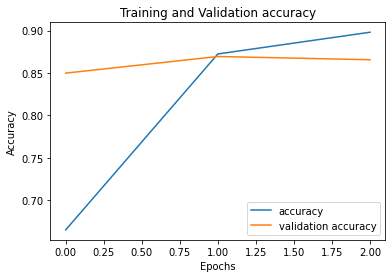

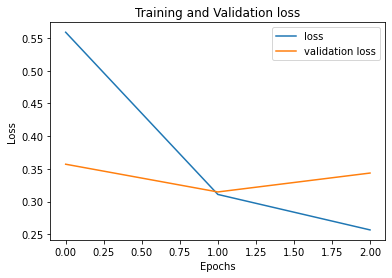

In [106]:
## plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation accuracy')
plt.legend(['accuracy','validation accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.legend(['loss','validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [107]:
model.evaluate(test_ds)

391/391 [==============================] - 1s 3ms/step - loss: 0.3201 - accuracy: 0.8724


[0.32010793685913086, 0.872439980506897]